# ________________________________________
# Tarefa 2 - Perceptron Multiclasse
# ________________________________________

## Bibliotecas base

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random

### Definição de funções auxiliares para criação de datasets sintéticos e visualização

In [2]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetBlobs(n=1000,n_classes=4,std=0.05):
  X,y = make_blobs(n_samples=n,centers=n_classes,center_box=(0,1.0),cluster_std=std)
  return X,y


def criaDatasetXOR(n=100):
  X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
  y =np.array(y%2,dtype=int)
  return X,y

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)


def plothiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

def plotHistory(hist):
  plt.plot(hist)

### Definição das classes para construção do Perceptron e seus hiperparâmetros

In [3]:
def sign(a):
  return (a>=0)*2-1

def accuracy(yactual,ypred):
  return sum(yactual==ypred)/len(yactual)

from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize

class TrainingAlgorithm(ABC):
  
  @abstractmethod
  def getW(self,X,y):
    pass

class Custo(ABC):
  @abstractstaticmethod
  def custo(y,ypred):
    pass
  @abstractstaticmethod
  def gradiente(y,ypred):
    pass


class WidrowHoff(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum((y - ypred)**2)
  
  @staticmethod
  def gradiente(y,ypred):
    return y - ypred

class SmoothedSurrogate(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),-y*ypred))

  @staticmethod
  def gradiente(y,ypred):
    return y - sign(ypred)


class HingeLoss(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),1-y*ypred))
  @staticmethod
  def gradiente(y,ypred):
    errosmarginais = (y*ypred)<1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return ymarginais



class LogLikehood(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.log(1+np.exp(-y*ypred)))
  
  @staticmethod
  def gradiente(y,ypred):
    return y-(expit(ypred)*2-1)

class PseudoInversa(TrainingAlgorithm):
  def __init__(self,history=[0]):
    self.history = history[0]
    
  def getW(self,X,y):
    return np.linalg.pinv(X) @ y


class PseudoInversaReg(TrainingAlgorithm):
  def __init__(self,history=[0],regularization=0):
    self.history = history[0]
    self.regularization = regularization
    
  def getW(self,X,y):
    w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])*self.regularization) @ X.T @ y
    return w


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self,max_iter=1000,learning_rate=0.01,early_stop=0,regularization=0.1,cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.early_stop = early_stop
    self.history=[]
    self.cost = cost

  def getW(self,X,y):
    w = np.random.uniform(-1,1,size=(X.shape[1],y.shape[1]))
    for j in range(self.max_iter):
      ypred = X @ w
      #erros = y - ypred
      custo = self.cost.custo(y,ypred) #np.sum(erros**2)
      if custo <= self.early_stop:
        self.history.append(custo)
        break
      w *= 1 - self.learning_rate*self.regularization
      w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate
      self.history.append(custo)
    return w

class Perceptron(ClassifierMixin,BaseEstimator):
  def __init__(self,training_algorithm=DescidaGradiente(),max_iter=1000,activation=sign):
    self.w = None
    self.max_iter=max_iter
    self.activation = activation
    self.training_algorithm = training_algorithm
  
  def fit(self,X,y):
    yhot = self.encode_labels(y)
    Xb = Perceptron.includeBias(X)
    self.w = self.training_algorithm.getW(Xb,yhot)
    return self.training_algorithm.history

  def predict(self,X,y=None):
    Xb = Perceptron.includeBias(X)
    a = Xb @ self.w
    ypred = self.activation(a)
    if self.w.shape[1] == 1:
      idx = np.array(a>0,dtype=int).reshape(-1)
    else:
      idx = np.argmax(a,axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2 -1

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb  

### Testes com dataset de classificação binária

0.99
[[-8.8373753 ]
 [ 4.37624692]] [1.88599701]
0.0040973962183255 0.991926857265304


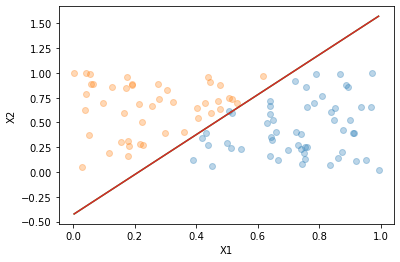

In [4]:
X,y = criaDataset(100)
perceptron = Perceptron(DescidaGradiente(learning_rate=0.01,max_iter=10000,cost=HingeLoss()))
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
print(min(X[:,0]),max(X[:,0]))

plotDataset(X, y)
for i in range(len(set(y))):
    plothiperplano(perceptron.w[1:], perceptron.w[0], min(X[:,0]), max(X[:,0]))
    #plothiperplano(perceptron.w[1:,i], perceptron.w[0,i])d

### Testes com datasets de classificação multilabel

1.0
[[-5.57963131 -5.13080567  5.81004609  8.94140666]
 [-4.73115948  5.29624497  5.06157079 -9.26029342]] [ 4.31411699 -0.79480589 -7.22060105 -2.40024992]
0.30627289343088154 0.890307145957662


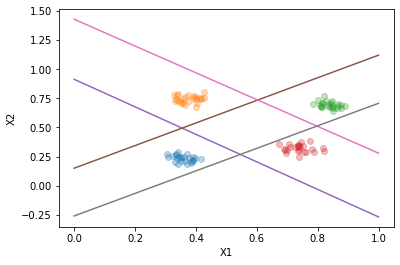

In [10]:
X,y = criaDatasetBlobs(100,4,std=0.03)
perceptron = Perceptron(DescidaGradiente(learning_rate=0.01,max_iter=10000,cost=HingeLoss()))
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
print(min(X[:,0]),max(X[:,0]))

plotDataset(X, y)
for i in range(len(set(y))):
    #plothiperplano(perceptron.w[1:,i], perceptron.w[0,i], min(X[:,0]), max(X[:,0]))
    plothiperplano(perceptron.w[1:,i], perceptron.w[0,i])

### Testes com dataset Iris, para classificação multilabel numérico e strings

In [6]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
data = load_iris()

0.94
[[-0.39259227 -0.21277881 -0.50746799]
 [ 0.74837452 -1.27256454 -0.63179674]
 [-0.98768185  1.72330695  3.48703763]
 [-1.15312517 -2.34305861  3.30590343]] [-0.91822248 -0.93095983 -4.0664374 ]
-1.87002413384702 2.492019202124427


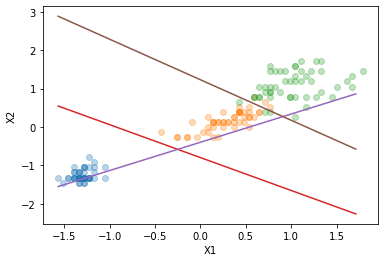

In [7]:
X = StandardScaler().fit_transform(data.data)
y = data.target

perceptron = Perceptron(DescidaGradiente(learning_rate=0.02,max_iter=1000,cost=HingeLoss()))
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
print(min(X[:,0]),max(X[:,0]))

plotDataset(X[:,[2,3]], y)
for i in range(len(set(y))):
    plothiperplano(perceptron.w[3:,i], perceptron.w[0,i], min(X[:,2]), max(X[:,3]))
    #plothiperplano(perceptron.w[1:,i], perceptron.w[0,i])

### Testes de classificação com labels em formato string

LABELS y: ['setosa' 'versicolor' 'virginica']
LABELS ypred: ['setosa' 'versicolor' 'virginica']
0.94
[[-0.28926881 -0.13336916 -0.47252045]
 [ 0.74571958 -1.24635433 -0.65131886]
 [-0.95288296  1.76312098  3.50232659]
 [-1.18172389 -2.31437204  3.31156114]] [-0.88795528 -0.92620493 -4.00962894]
-1.87002413384702 2.492019202124427


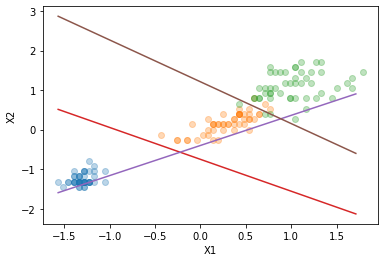

In [8]:
X = StandardScaler().fit_transform(data.data)
y = np.array([data['target_names'][i] for i in data.target])
print('LABELS y:', np.unique(y))
yenc = data.target

perceptron = Perceptron(DescidaGradiente(learning_rate=0.02,max_iter=1000,cost=HingeLoss()))
perceptron.fit(X, y)
ypred = perceptron.predict(X)
print('LABELS ypred:',np.unique(ypred))
print(sum(y == ypred)/len(y))
print(perceptron.w[1:], perceptron.w[0])
print(min(X[:,0]),max(X[:,0]))

plotDataset(X[:,[2,3]], yenc)
for i in range(len(set(y))):
    plothiperplano(perceptron.w[3:,i], perceptron.w[0,i], min(X[:,2]), max(X[:,3]))
    #plothiperplano(perceptron.w[1:,i], perceptron.w[0,i])